In [ ]:
import torch
import torchvision
import zipfile
from PIL import Image as im

In [ ]:
from fastai import *
from fastai.vision import *
# from fastai.callbacks import *
import glob
import cv2
import numpy as np

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import json
from random import random

import os
from itertools import combinations
# from itertools import permutations
from PIL import Image
#upper_left=(0,0)  upper_right=(640,0)  lower_left=(0,480)  lower_right=(640,480) for images from labelme


# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)

cuda:0


In [ ]:
path_images='/content/drive/MyDrive/Stair dataset1/train'
path_valid='/content/drive/MyDrive/Stair dataset1/val'
fnames=get_image_files(path_images)

In [ ]:
class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

pathlib.PosixPath

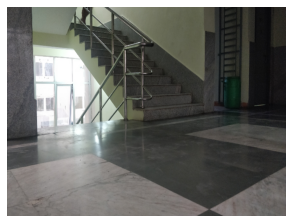

In [ ]:
img_f = fnames[421]
img = open_image(img_f) #img_f is of type Posix_path
img.show(figsize=(5,5))
type(img_f)

In [ ]:
import posixpath
get_y_fn = lambda x: (posixpath.join('/content/drive/MyDrive/Stair dataset1/train_pngs',f'{x.stem}{x.suffix}')) if (x.parent.stem == 'train') else (posixpath.join('/content/drive/MyDrive/Stair dataset1/val_pngs',f'{x.stem}{x.suffix}'))

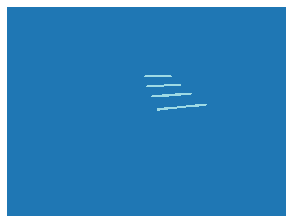

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
colors = np.loadtxt('/content/drive/MyDrive/Stair dataset1/stair.txt',delimiter='\n',dtype=str)

In [ ]:
"""Run this for training as during training size is 1/2 nd testing size is same as original (480,640)"""
src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/Stair dataset1'))
   .split_by_folder(train='train',valid='val')
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=src_size//2)#tfms_y=True because transforms we r applying on trainset,will be also applied on train_masks
   .add_test_folder(test_folder='test',tfms=None,tfm_y=False)#since test_masks are empty we dont need tfms on ground truth here so tfm_y=False
   )


/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
# tfms = get_transforms(do_flip=True,size=src_size//2)
data = (src
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data,models.resnet34)

In [ ]:
learn.load('stage-2-unfreeze')

Learner(data=ImageDataBunch;

Train: LabelList (485 items)
x: SegItemListCustom
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: SegLabelListCustom
ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320)
Path: /content/drive/MyDrive/Stair dataset1;

Valid: LabelList (97 items)
x: SegItemListCustom
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: SegLabelListCustom
ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320),ImageSegment (1, 240, 320)
Path: /content/drive/MyDrive/Stair dataset1;

Test: LabelList (96 items)
x: SegItemListCustom
Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320),Image (3, 240, 320)
y: EmptyLabelList
,,,,
Path: /content/drive/MyDrive/Stair dataset1, model=DynamicUnet(
  (layers): ModuleList(
    (0

In [ ]:
# dataroot="/content/drive/MyDrive/Stair dataset/results/mask"

def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
        Parameters:
            image: The output of a Canny transform.
    """
    rho = 1            #Distance resolution of the accumulator in pixels.
    theta = np.pi/180    #Angle resolution of the accumulator in radians.
    threshold = 87      #Only lines that are greater than threshold will be returned.
    minLineLength = 10   #Line segments shorter than that are rejected.
    maxLineGap = 350     #Maximum allowed gap between points on the same line to link them
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)
    
def polyarea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
# PolygonArea([[0,0],[0,4],[4,4],[4,0]])

def get_intersection(i):
  x1=i[0][0]
  y1=i[0][1]
  x2=i[0][2]
  y2=i[0][3]
  x3=i[1][0]
  y3=i[1][1]
  x4=i[1][2]
  y4=i[1][3]
  if (x1-x2) ==0 or (x3-x4) ==0 :
    return(0,0)
  else:
    b=(y1-y2)/(x1-x2)
    a=(y3-y4)/(x3+x4)
    a1=(y3-a*x3)
    b1=(y1-b*x1)
    if (b-a) ==0 :
      return (0,0)
    else:
      X=(a1-b1)/(b-a)
      Y=b*(X-x1)+y1
      return (X,Y)


In [ ]:
def apply_resnet(arr,save=True):
    test_image = Image(pil2tensor(arr, dtype=np.float32).div_(255))
    img_segment = learn.predict(test_image)[0]
    test_image_data=test_image.data.permute(1,2,0)
    img_segment_data=img_segment.data*255
    img_segment_data=img_segment_data.permute(1,2,0)
    mask=img_segment.data.permute(1,2,0).numpy()
    mask=(np.squeeze(mask,axis=2))*255
    # plt.imshow(mask)
    # plt.show()
    # print(mask.shape)
    return mask

def process_mask(mask):
  stair_mask = np.zeros((240,320),np.uint8)
  stair_mask[ymin:ymax,xmin:xmax] = mask[ymin:ymax,xmin:xmax] 
  img=np.stack((stair_mask,stair_mask,stair_mask),axis=-1)
  img = cv2.copyMakeBorder( img, 10,10,10,10, cv2.BORDER_CONSTANT)

  # find all your connected components (white blobs in your image)
  nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img[:,:,0], connectivity=8)  #connectivity =4(erodes more) or 8(erodes less)
  #connectedComponentswithStats yields every seperated component with information on each of them, such as size
  #the following part is just taking out the background w[[275, 175, 559, 200]],which is also considered a component, but most of the time we don't want that.
  sizes = stats[1:, -1]
  nb_components = nb_components - 1
  # minimum size of particles we want to keep (number of pixels)
  #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
  min_size = 20
  img2 = np.zeros((img.shape),dtype=np.uint8)
  img3 = np.zeros((img.shape),dtype=np.uint8)
  # img4 = np.zeros((img.shape),dtype=np.uint8)
  #for every component in the image, you keep it only if it's above min_size
  for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255

  lines=hough_transform(img2[:,:,0])
  try:
    if lines is not None:
      for line in lines:
        x1,y1,x2,y2=line[0][0],line[0][1],line[0][2],line[0][3]
        cv2.line(img3,(x1,y1), (x2,y2), (255,255,255),2) 

        #THESE X1,Y1 & X2,Y2 VALUES WILL BE USED USED TO CALCULATE HORIZONTAL POINTS(AS EQN CAN BE FOUND FROM HERE N THEN NC2 POINT INTERSECTION ND USKA MEAN/MEDIAN/MODE)
        # cv2.circle(img4,(x1,y1),3,[0,255,0],-1)
        # cv2.circle(img4,(x2,y2),3,[0,255,0],-1)

    operatedImage = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)  
    dest = cv2.cornerHarris(operatedImage, 5, 31, 0.2) 
    dest = cv2.dilate(dest, None) 
    result=np.where(dest > 0.02 * dest.max())
    list1=[]
    list2=[]
    boolean=True
    for num in range(result[0].shape[0]):
      while boolean:
        list1.append(result[0][num])
        list2.append(result[1][num])
        boolean=False
      if np.abs(result[0][num]-list1[-1])>5 or np.abs(result[1][num]-list2[-1])>5:         #TRY REMOVING ABSOLUTE
        list1.append(result[0][num])
        list2.append(result[1][num])
    for num in range(len(list1)):
      cv2.circle(img3,(list2[num],list1[num]),3,[0,255,0],-1)  #BGR FORMAT 

    #caculation os area of stair
    stair_area= polyarea(list1,list2)
    label_html = '(1) stair case area is ' + str(stair_area)
    #---------------------------------------------------------------------------print('stair case area is {}'.format(stair_area))
    #Seperating left and right corners of stair
    X=np.array(list(zip(list2,list1)))
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X)
    res=list(zip(*X[kmeans.labels_==0]))
    res1=list(zip(*X[kmeans.labels_==1]))
    for num in range(len(res[0])):
      cv2.circle(img3,(res[0][num],res[1][num]),2,[255,0,0],-1)
    for num in range(len(res1[0])):
      cv2.circle(img3,(res1[0][num],res1[1][num]),2,[0,0,255],-1)

    # plt.gca().invert_yaxis()  #to shift origin to upperleft corner
    x=np.array(res[0]).reshape(-1,1)
    y=np.array(res[1]).reshape(-1,1)
    x1=np.array(res1[0]).reshape(-1,1)
    y1=np.array(res1[1]).reshape(-1,1)
    reg = LinearRegression()
    reg.fit(x,y)
    reg1 = LinearRegression()
    reg1.fit(x1,y1)
    c=np.squeeze(reg1.coef_)
    d=np.squeeze(reg1.intercept_)
    b=np.squeeze(reg.intercept_)
    a=np.squeeze(reg.coef_)

    #---------------------------------------------------------------------------print("The linear model is: Y = {:.5} + {:.5}X".format(b,a))  #b a 
    #---------------------------------------------------------------------------print("The linear model is: Y = {:.5} + {:.5}X".format(d,c))  #d c

    #calculation of theta i.e angle between two lines
    slope= np.arctan(np.abs((a-c)/(1 + a*c)))
    slope = (slope*180)/np.pi
    #---------------------------------------------------------------------------print("The angle between these two lines is {}".format(slope)) 
    label_html = label_html + ' (2) The angle between these two lines is ' + str(slope)

    try :
      predictions=np.squeeze(reg.intercept_)+np.squeeze(reg.coef_) *x
      predictions1=np.squeeze(reg1.intercept_)+np.squeeze(reg1.coef_) *x1
      linewidth=2
      
      X_intersection=(d-b)/((a-c)+2)
      Y_intersection=a*X_intersection+b +1
      label_html =label_html + ' (3) vertical vanishing point is ' + str(X_intersection) +',' + str(Y_intersection)
      #-------------------------------------------------------------------------print('vertical vanishing point is {}'.format((X_intersection,Y_intersection)))
      
    except:
        a=10
        print('done1')


    #calculate horizontal intersection point
    try:
      line_cords=[]
      lines=hough_transform(img3[:,:,0])
      if lines is not None:
        for line in lines:
          # if random() > 0.2:
          x1,y1,x2,y2=line[0][0],line[0][1],line[0][2],line[0][3]
          line_cords.append((x1,y1,x2,y2))
          x=[x1,x2]
          y=[y1,y2]

      count=0 
      x0=0
      y0=0
      comb_line_cords=list(combinations(line_cords, 2))
      for i in comb_line_cords:
          # print(i)
          if get_intersection(i)==(0,0):
            count-=1
          else:
            x0+=get_intersection(i)[0]
            y0+=get_intersection(i)[1]
            count+=1
      x_mean=x0/(count+2)
      y_mean=y0/(count+2)
      label_html = label_html + ' (4) horizontal vanishing point is ' + str(x_mean) +',' + str(y_mean) 
      #-------------------------------------------------------------------------print('horizontal vanishing point is {}'.format((x_mean,y_mean)))

    except:
      b=20
      # ------------------------------------------------------------------------print('done2')
    # --------------------------------------------------------------------------print(label_html)
    return label_html

  except:
    label_html = 'No stair edge detected'
    return label_html


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
!pip install PyYAML

In [ ]:
model = torch.hub.load('ultralytics/yolov5',  'custom', path='/content/drive/MyDrive/Stair dataset1/yolo_weights/best3.pt', force_reload=True)  # or yolov5m, yolov5l, yolov5x, custom

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2021-12-6 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def apply_yolov5(bbox_array, img):
  res = model(img)
  try: 
    l = res.xyxy[0]  
    xmin = int(l[0,0]/2)
    ymin = int(l[0,1]/2)
    xmax = int(l[0,2]/2)
    ymax = int(l[0,3]/2)
    return cv2.rectangle(bbox_array,(xmin,ymin),(xmax,ymax),(255,0,0),2), xmin, xmax, ymin, ymax
  except: 
    return bbox_array, 0, 320, 0, 240

In [ ]:
from fastai.vision import *

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([240,320,4], dtype=np.uint8)
    
    bbox_array, xmin, xmax, ymin, ymax = apply_yolov5(bbox_array, img)
    mask = apply_resnet(img)
    
    filtered_mask = np.zeros((240,320))
    filtered_mask[ymin:ymax,xmin:xmax] = mask[ymin:ymax, xmin:xmax]
    
    bbox_array[:,:,1] = filtered_mask
  # bbox_array[:,:,1] = mask
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
  
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    label_html = process_mask(mask)
    

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: divide by zero encountered in double_scalars


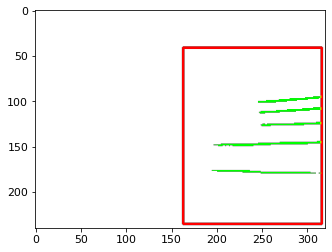

In [ ]:
plt.imshow(bbox_array)